##Plotting Spectra

We are plotting fluorescence assay spectra collected according to this lab-protocols protocol.
Further details of the specific experiment can be found in the fluorescence assay lab notebook on December 15-18, 2015.

In [1]:
from lxml import etree
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
%matplotlib inline

Here each set of files is for a specific protein on one 96 well plate, and each file is a set of two rows that corresponds to a gradient of one ligand, with the first row being 1 uM of the protein and the second row containing only buffer and the ligand. This an example of a single plate (containing 1 uM of one type of protein in every other well):

Loading in files and defining proteins and ligands and their order in the data:

In [2]:
file_set = {'Src': glob("2015-12-15/*.xml"),
        'SrcGK': glob("2015-12-16/*.xml"),
        'AblGK': glob("2015-12-17/*.xml"),
        'Abl': glob("2015-12-18/*.xml")}
ligands = ['Bosutinib','Bosutinib Isomer','Erlotinib','Gefitinib']

In [3]:
#Src = glob("2015-12-15/*.xml")
#SrcGK = glob("2015-12-16/*.xml")
#AblGK = glob("2015-12-17/*.xml")
#Abl = glob("2015-12-18/*.xml")
#files = [Src,SrcGK,Abl,AblGK]

In [5]:
#This function allows us to import xml format data files and convert them to a pandas dataframe
def xml2df(file):

    root = etree.parse(file)

    data = []

    reads = root.xpath("/*/Section[1]/*/Well")

    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(s.text, float(s.attrib['WL']), r.attrib['Pos'])
        for r in reads
        for s in r]

    dataframe = pd.DataFrame(data, columns=['fluorescence','wavelength (nm)','Well'])
            
    ### dataframe_rep replaces 'OVER' (when fluorescence signal maxes out) with '3289277', an arbitrarily high number

    dataframe_rep = dataframe.replace({'OVER':'3289277'})

    dataframe_rep[['fluorescence']] = dataframe_rep[['fluorescence']].astype('float')
            
    dataframe_pivot = pd.pivot_table(dataframe_rep, index = 'wavelength (nm)', columns = ['Well'])
    
    #Rearrange columns so they're in the right order
    cols =  dataframe_pivot['fluorescence'].columns.tolist()
    cols = [cols[0]] + cols[4:11] + cols[1:4] + [cols[12]] + cols[16:23] + cols[13:16]
    dataframe_reindex =  dataframe_pivot.reindex_axis(cols,level='Well',axis=1)
    
    return dataframe_reindex

In [6]:
dataframe = xml2df(Src[0])

In [7]:
dataframe.head()

fluorescence                                               \
Well                      A1       A2       A3       A4       A5       A6   
wavelength (nm)                                                             
280                  3289277  3289277  3289277  3289277  3289277  3289277   
285                  3289277  3289277  3289277  3289277  3289277  3289277   
290                  3289277  3289277  3289277  3289277  3289277  3289277   
295                  3289277  3289277  3289277  3289277  3289277  3289277   
300                  3289277  3289277  3289277  3289277  3289277  3289277   

                                                      ...              \
Well                  A7       A8      A10      A11   ...          B2   
wavelength (nm)                                       ...               
280              3289277  3289277  3289277  3289277   ...     3289277   
285              3289277  3289277  3289277  3289277   ...     3289277   
290              3289277  3289277  3289277  3289277   ...     3289277   
295              3289277  3289277  3289277  3289277   ...     3289277   
300              3289277  3289277  3289277  3289277   ...     3289277   

                                                                       \
Well                  B3       B4       B5       B6       B7       B8   
wavelength (nm)                                                         
280              3289277  3289277  3289277  3289277  3289277  3289277   
285              3289277  3289277  3289277  3289277  3289277  3289277   
290              3289277  3289277  3289277  3289277  3289277  3289277   
295              3289277  3289277  3289277  3289277  3289277  3289277   
300              3289277  3289277  3289277  3289277  3289277  3289277   

                                            
Well                 B10      B11      B12  
wavelength (nm)                             
280              3289277  3289277  3289277  
285              3289277  3289277  3289277  
290              3289277  3289277  3289277  
295              3289277  3289277  3289277  
300              3289277  3289277  3289277  

[5 rows x 22 columns]

In [8]:
#This function allows us to plot spectra
def plot_spectra_grid(file_set,protein,ligands,ligand):
    grid = len(protein) + len(ligand)
    
    # pick the correct file
    proteins = file_set.keys()
    index = ligands.index(ligand)
    file = file_set[protein][index]
    
    # pick a title
    title = "%s - %s" %(protein, ligand)
    
    df = xml2df(file)
    
    # plot the spectra
    fig = plt.figure();
    ax = df['fluorescence'].iloc[:,12].plot(ylim=(0,100000),legend=False, linewidth=4,color='m');
    ax.axvline(x=480,color='0.7',linestyle='--');
    for i in range(11):
        #s = df['fluorescence'].iloc[:,i].plot(ylim=(0,100000),linewidth=3,c=cm.hsv(i*15), ax = ax, title=title);
        df['fluorescence'].iloc[:,i].plot(ylim=(0,100000),linewidth=3,c=cm.hsv(i*15), ax = ax, title=title);
        df['fluorescence'].iloc[:,11+i].plot(ylim=(0,100000),legend=False, linewidth=4,c=cm.gray(i*15+50), ax = ax);
    
    # The s = line above and this an attempt at making a color bar that so far has not worked
    #cbar = plt.colorbar(mappable=s, ax=ax)
    #cbar.set_label('My Label')
    

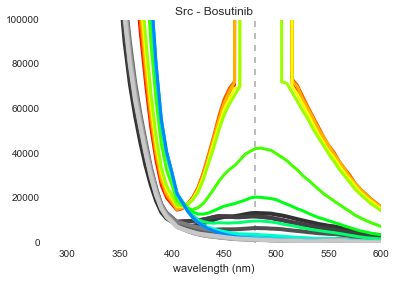

In [9]:
#You can use it to generate a single plot
plot_spectra_grid(file_set,'Src',ligands,'Bosutinib')

In [10]:
# or eventually it will also give a matrix of plots

In [11]:
#this function allows us to plot the saturation curve at a single wavelength of the spectra
def plot_spectra2singlet(file_set,ligands,wavelength):
    
    fig, axes = plt.subplots(nrows=len(file_set), ncols=4, figsize=(22,22))
    
    proteins = file_set.keys()
    
    for j,protein in enumerate(file_set):
    
        files = file_set[protein]
        print file_set[protein]
    
        for i in range(len(files)):
        
            #Extract data from the xml file and make a dataframe
            df = xml2df(files[i])

            hardcode = wavelength #nm
     
            # This plots things.
            df.loc[hardcode][0:11].plot(ax = axes[j,i], xticks=[],linewidth=4)
            df.loc[hardcode][11:23].plot(ax = axes[j,i], xticks=[],linewidth=4,title ='%s - %s' %(proteins[j], ligands[i]))
        plt.text(4,20000,'wavelength %s nm'%hardcode,fontsize=20)
            

['2015-12-17/AblD382N-T334I_Bos_20151217_bw2020_gain120_120553.xml', '2015-12-17/AblD382N-T334I_BosI_20151217_bw2020_gain120123031.xml', '2015-12-17/AblD382N-T334I_Erl_20151217_bw2020_gain120_125515.xml', '2015-12-17/AblD382N-T334I_Gef_20151217_bw2020_gain120_132641.xml']
['2015-12-15/Src_Bos_20151215_bw2020_gain120_161211.xml', '2015-12-15/Src_BosI_20151215_bw2020_gain120_163633.xml', '2015-12-15/Src_Erl_20151215_bw2020_gain120_170056.xml', '2015-12-15/Src_Gef_20151215_bw2020_gain120_172518.xml']
['2015-12-18/AblD382N_Bos_20151218_bw2020_gain120_ 14-41-14_plate_1.xml', '2015-12-18/AblD382N_BosI_20151218_bw2020_gain12014-55-55_plate_1.xml', '2015-12-18/AblD382N_Erl_20151218_bw2020_gain120 15-11-11_plate_1.xml', '2015-12-18/AblD382N_Gef_20151218_bw2020_gain120 15-25-58_plate_1.xml']
['2015-12-16/SrcT338I_Bos_20151216_bw2020_gain120_152505.xml', '2015-12-16/SrcT338I_BosI_20151216_bw2020_gain120_154934.xml', '2015-12-16/SrcT338I_Erl_20151216_bw2020_gain120_161404.xml', '2015-12-16/SrcT338

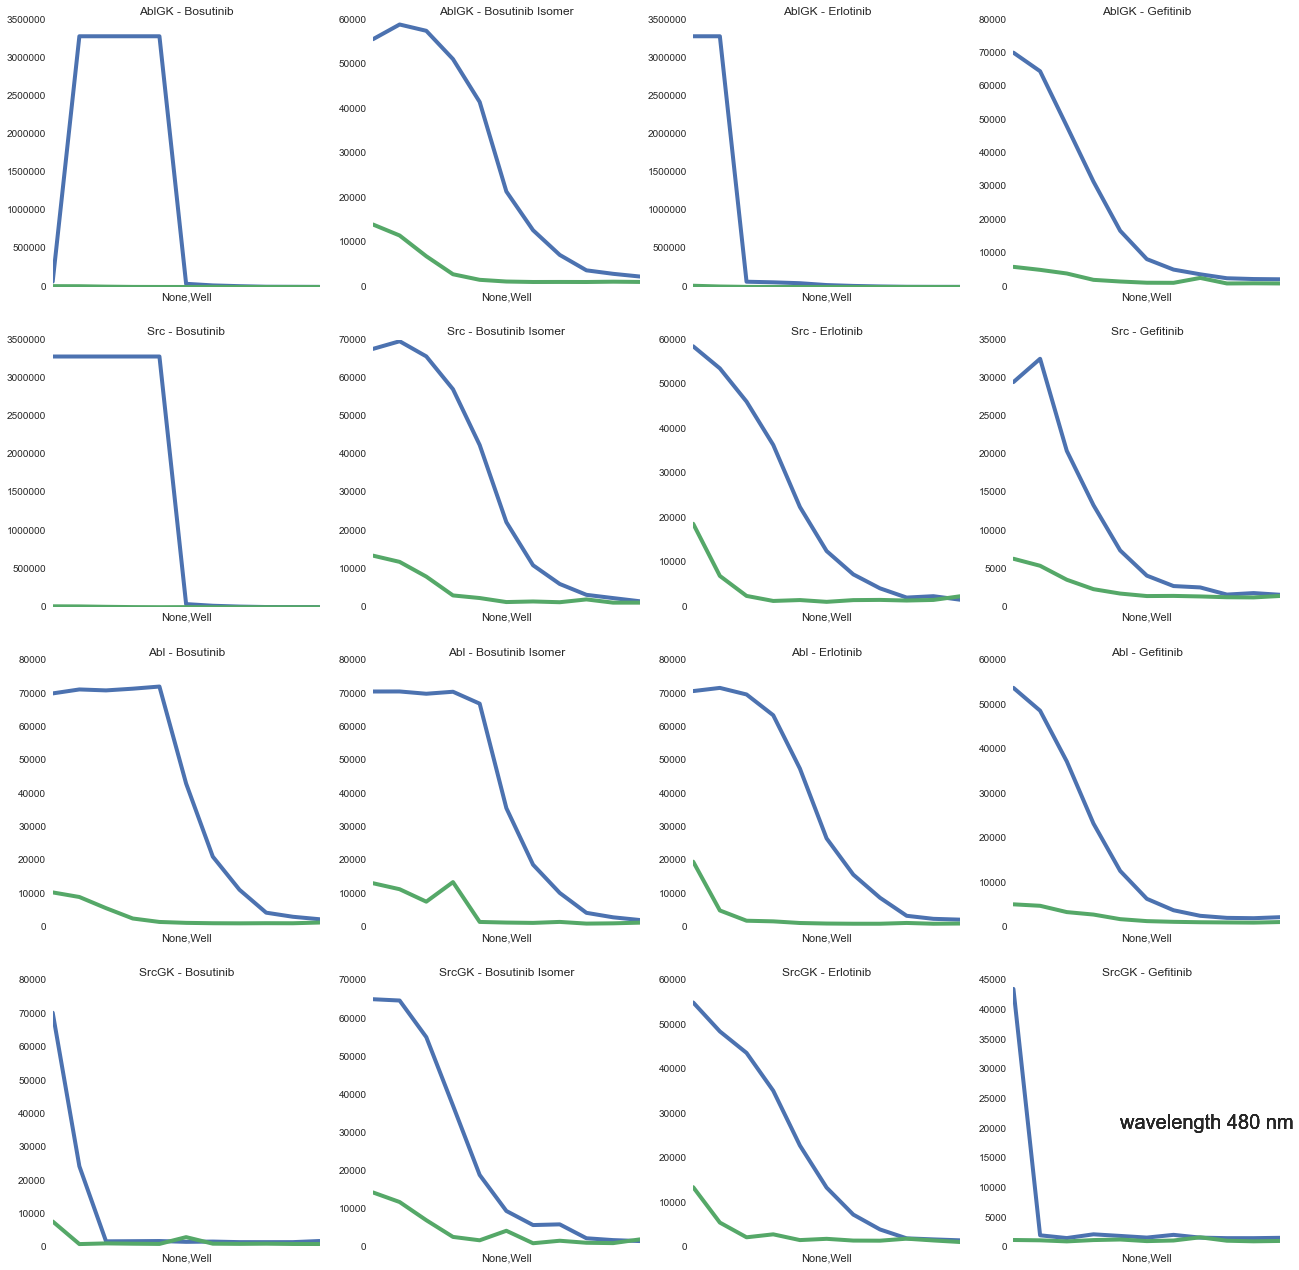

In [12]:
#This works for both a full set of proteins
plot_spectra2singlet(file_set,ligands,480)

In [13]:
# or just one protein
#  This actually doesn't work for some reason
#Src = {'Src': glob("2015-12-15/*.xml")}
#plot_spectra2singlet(Src,ligands,480)
#  ERROR
#  too many indices for array
#  ---> 21             df.loc[hardcode][0:11].plot(ax = axes[j,i], xticks=[],linewidth=4)